In [41]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2


/home/xabush/pln-brca-xp/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from utils import *
from utils_emb import *

In [43]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/merged-combat15.csv.xz", index_col="patient_ID")


In [44]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])

#### Use only Genes whose mean expression value is greater than or equal to 5

In [45]:
feats_diff = load_features("/var/www/datasets/filteredGenes4studies.txt")
non_embedded = load_features("datasets/non_embedded_genes_list.txt")
feats_diff_filtered = list(set(feats_diff) - set(non_embedded))
len(feats_diff_filtered)

4382

In [8]:
with open("datasets/filteredGenes4studies_emb.txt", "w") as fp:
    print_array(feats_diff_filtered, fp)

In [46]:
X, y = ge_tamx_df[feats_diff_filtered], ge_out_tamx_df["posOutcome"]
#X.to_csv("/var/www/datasets/ge_tamoxifen_mean_filtered.csv", index=True)

In [47]:
df = X.join(y)
params_v1, clf_v1, cv_scores_v1, test_scores_v1 = evaluate_ge(df)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[22:07:18] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 1 minutes and 54.51 seconds.
Best Score: 68.666%
{'subsample': 0.6, 'scale_pos_weight': 0.7, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'max_delta_step': 4, 'learning_rate': 0.05, 'gamma': 2, 'colsample_bytree': 0.8}
[22:07:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric use

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.7min finished


In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 16))
plot_importance(clf_v1, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

#### Generate List 1 genes using XGB to rank the genes by gain

In [50]:
feature_importance_g= clf_v1.get_booster().get_score(importance_type='gain')
ranked_features_g = {k: v for k, v in sorted(feature_importance_g.items(), key=lambda x: x[1], reverse=True)}
ranked_genes_g = [gene for gene in ranked_features_g]
top_500_v1 = ranked_genes_g[:500]
top_500_v1[:10]

['AATF',
 'CRABP2',
 'UBE2V2',
 'CX3CR1',
 'AHR',
 'PLA2G12A',
 'RAD1',
 'EEF1E1',
 'AP3M2',
 'CNN3']

In [51]:
pop_genes = X.columns.to_list()
# pop_genes = [x for x in X_17705.columns.to_list() if x not in feat_diff_exp]
len(pop_genes)

4382

In [52]:
from convert_symbol_to_entrez import read_symbol2geneid

sym2geneid = read_symbol2geneid("datasets/Homo_sapiens.gene_info")

  126,696 READ: datasets/Homo_sapiens.gene_info


#### Use GOATools to get list 1

In [56]:
go_lst_1_df = run_gene_enrich(top_500_v1, pop_genes, "datasets/pln_goa_comp_direct/list_1", sym2geneid)

datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms; optional_attrs(relationship)
HMS:0:00:05.179896 335,863 annotations, 20,672 genes, 18,441 GOs, 1 taxids READ: gene2go 
Study: 500 vs. Population 4382


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 97%  4,250 of  4,382 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 99%  4,328 of  4,382 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 98%  4,296 of  4,382 population items found in association

Run BP Gene Ontology Analysis: current study set of 500 IDs ... 97%    487 of    500 study items found in association
100%    500 of    500 study items found in population(4382)
Calcu

In [58]:
display(go_lst_1_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:1902017,BP,e,regulation of cilium assembly,7/500,14/4382,0.000404,8,7,1.0,1.0,1.0,1.0,"1540, 3985, 8558, 8655, 9474, 51626, 79874"
1,GO:0002052,BP,e,positive regulation of neuroblast proliferation,4/500,5/4382,0.000763,8,4,1.0,1.0,1.0,1.0,"1524, 2737, 3091, 6376"
2,GO:0060628,BP,e,regulation of ER to Golgi vesicle-mediated tra...,5/500,8/4382,0.000791,6,5,1.0,1.0,1.0,1.0,"6653, 11236, 23256, 53407, 56681"
3,GO:2000179,BP,e,positive regulation of neural precursor cell p...,6/500,12/4382,0.001082,6,6,1.0,1.0,1.0,1.0,"1524, 2316, 2737, 2771, 3091, 6376"
4,GO:0002009,BP,e,morphogenesis of an epithelium,21/500,92/4382,0.001406,4,21,1.0,1.0,1.0,1.0,"1512, 2099, 2737, 2885, 3091, 3169, 3714, 3845..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,GO:0001103,MF,e,RNA polymerase II repressing transcription fac...,4/500,12/4382,0.039273,6,4,1.0,1.0,1.0,1.0,"2958, 3066, 5932, 9112"
332,GO:0035035,MF,e,histone acetyltransferase binding,4/500,12/4382,0.039273,4,4,1.0,1.0,1.0,1.0,"2737, 3091, 5111, 6772"
333,GO:0051059,MF,e,NF-kappaB binding,5/500,18/4382,0.046072,6,5,1.0,1.0,1.0,1.0,"328, 2932, 3066, 8915, 11124"
334,GO:0044183,MF,e,protein folding chaperone,5/500,18/4382,0.046072,1,5,1.0,1.0,1.0,1.0,"811, 3303, 3309, 5201, 10576"


In [57]:
go_lst_1_df = pd.read_csv("datasets/pln_goa_comp_direct/goa_ge_list_1.csv")

In [59]:
go_lst_1 = list(go_lst_1_df.sort_values(by="p_uncorrected")["# GO"])

In [80]:
# patient_ppt = pd.read_table("datasets/patients_exp/property_vector_beforekpca_p=1,T=2_notnormalized_2021-05-05.csv", index_col="patient_ID")
# display(patient_ppt)

gene_ppt = pd.read_table("datasets/genes_exp/property_vector_beforekpca_p=1,T=2_notnormalized_2021-05-09.csv", index_col="node_ID")
display(gene_ppt)


,GO:0071279,GO:0120031,GO:0000176,GO:0052740,GO:0015860,GO:0005402,GO:0072718,GO:0048019,GO:0002889,GO:1901098,...,GO:0036506,GO:0048496,GO:0000803,GO:0061518,GO:0097338,GO:0060287,GO:0019374,GO:0051011,GO:0055129,GO:0072207
node_ID,,,,,,,,,,,,,,,,,,,,,
MRPS27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SNRPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USP16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HK2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNAJB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATP8B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
import re
pat = re.compile("(GO:\d+|R\-HSA\-\d+|PA\d+$|^\$)")
gene_cols = [x for x in patient_ppt.columns.to_list() if not pat.match(x)]
print(set(feats_diff_filtered) - set(gene_cols))

{'MCM2'}


In [64]:
patient_ppt[gene_cols].shape

(649, 4381)

In [65]:
print(set(gene_cols) - set(feats_diff_filtered))

set()


In [66]:
patient_gene_df = patient_ppt[gene_cols]

#### 1.1 Generate KPCA embedded space based on patients' gene property vectors

In [67]:
K_tan = kernel_func(patient_gene_df.values, patient_gene_df.values)
kpca = KernelPCA(kernel="precomputed")
X_patient_emb = kpca.fit_transform(K_tan)
X_patient_emb = pd.DataFrame(X_patient_emb, index=patient_ppt.index)
display(X_patient_emb)

,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
patient_ID,,,,,,,,,,,,,,,,,,,,,
249600,-0.215897,-0.066028,0.053141,0.061013,0.024761,0.066333,0.043992,0.187272,0.015304,0.258978,...,-0.000660,0.000068,0.000235,-0.000360,0.000009,0.000184,-0.000154,-0.000293,0.000382,6.938269e-02
441891,0.079518,-0.016812,-0.113464,0.072927,0.268177,-0.013270,-0.088285,0.086124,-0.067969,-0.025023,...,-0.001604,0.003259,0.001770,0.001175,-0.002190,0.002006,0.000462,-0.000032,-0.000542,8.878797e-05
249532,0.673793,0.218651,0.031425,0.100327,-0.073267,0.310880,-0.006423,-0.029022,-0.034479,0.000040,...,0.054993,-0.066701,-0.097629,-0.066496,0.059972,-0.091717,0.163766,-0.069837,0.005090,1.065136e-04
22476,0.030521,-0.126861,-0.176750,0.185940,-0.062552,-0.100849,0.172097,-0.003070,-0.014581,0.035171,...,0.001568,0.001055,-0.001236,0.000690,0.001163,-0.001379,0.000472,-0.001219,-0.000751,5.043831e-05
441736,-0.045285,0.072010,0.161457,-0.074412,0.055315,-0.048229,-0.041260,0.075996,-0.165867,-0.047498,...,0.002046,0.001177,-0.001461,0.000720,-0.000339,-0.000126,0.000834,-0.000226,-0.000528,-1.108444e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305149,-0.057991,0.245433,-0.153563,-0.000540,0.136760,0.007418,0.073525,0.094536,0.163288,-0.167934,...,-0.001226,-0.003875,-0.002358,0.000283,0.000158,0.001475,0.001312,0.001988,0.000515,5.504821e-05
441821,0.016787,-0.052134,0.181571,-0.172584,-0.071489,-0.076770,0.136989,0.014525,-0.257216,-0.064968,...,0.001383,-0.002296,-0.000743,-0.000752,0.000003,-0.000227,-0.000311,0.001085,0.000677,-2.247287e-04
305164,0.131797,-0.251756,-0.123238,0.013993,-0.136532,-0.064119,-0.115201,0.085587,0.042829,-0.007863,...,0.000259,-0.000245,0.002036,-0.000311,0.001784,-0.001554,-0.000274,-0.000864,-0.000635,-4.506043e-07


In [68]:
df_emb = X_patient_emb.join(y)
params_v2, clf_v2, cv_scores_v2, test_scores_v2 = evaluate_ge(df_emb)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[22:14:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:14:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 19.62 seconds.
Best Score: 63.983%
{'subsample': 0.6, 'scale_pos_weight': 0.3, 'n_estimators': 120, 'min_child_weight': 2, 'max_depth': 4, 'max_delta_step': 4, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.6}
[22:14:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric u

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   18.1s finished


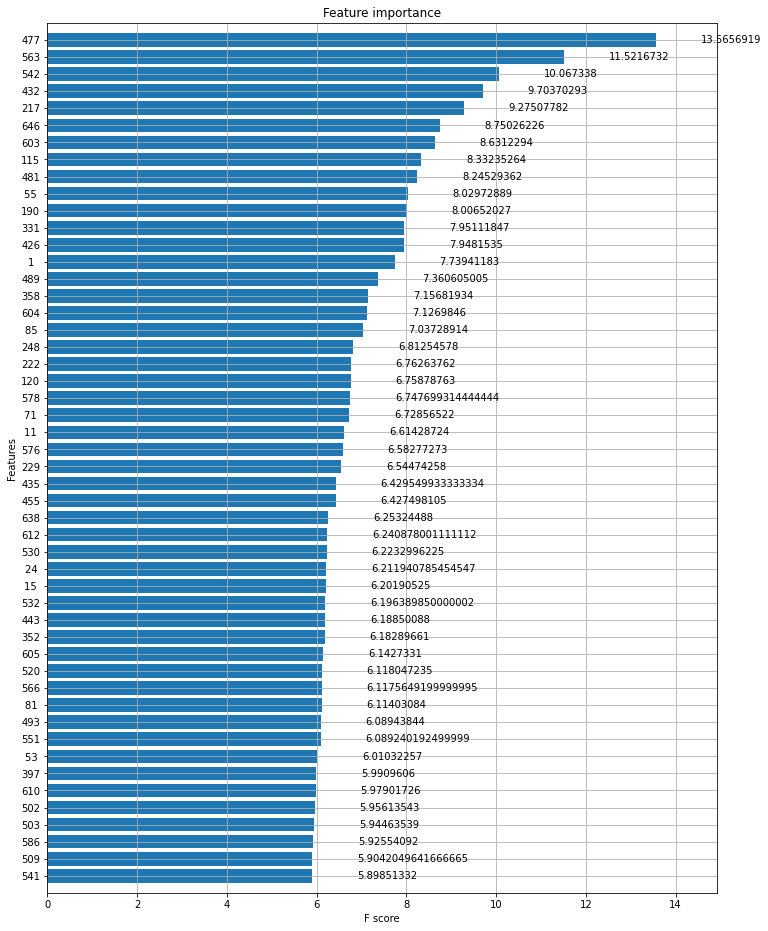

In [53]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 16))
plot_importance(clf_v2, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

#### 1.2 Rank the components with XGBoost and generate v with the relevance values

This returns a vector V whose i'th element shows the score/rank of the the i'th PC

In [69]:
feature_importance_g_2= clf_v2.get_booster().get_score(importance_type='gain')
feat_scores_v2 = {}
for k, v in feature_importance_g_2.items():
    feat_scores_v2[int(k.strip())] = v

for c in X_patient_emb.columns:
    if c not in feat_scores_v2:
        feat_scores_v2[c] = 0

v_emb = [v for k, v in sorted(feat_scores_v2.items(), key=lambda x: x[0])]
v_emb = np.array(v_emb)
v_emb.shape

(648,)

#### 1.3  For each GO category associate a gene property vector

In [70]:
go_gene_df = gene_ppt.T
display(go_gene_df)

node_ID,MRPS27,SNRPC,USP16,ACACA,HK2,LRPAP1,HTR4,DNAJB12,POLR1C,ACTR2,...,LYPLA2,RXRB,MAP7,MICAL2,IL13RA1,TBC1D2B,DNAJB2,ATP8B1,DPP3,OLFML2B
GO:0071279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0120031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0052740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0015860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0060287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0019374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0051011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0055129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
np.count_nonzero(go_gene_df.values)

524274

#### 1.4  Embed these GO categories in the embedded space obtained in 1.1

In [95]:
K_go = kernel_func(go_gene_df.values, patient_gene_df.values)
K_go.shape


(16495, 649)

In [97]:
go_emb = kpca.transform(K_go)
print("K_go shape: " + str(K_go.shape))
print("go_emb shape: " + str(go_emb.shape))

K_go shape: (16495, 649)
go_emb shape: (16495, 648)


In [98]:
go_emb_df = pd.DataFrame(go_emb, index=go_gene_df.index)
display(go_emb_df)

,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
GO:0071279,0.009791,-0.025321,0.055292,0.053011,-0.067171,0.017816,0.027253,0.090010,0.054210,0.008088,...,-0.001577,0.000778,0.002870,-0.007410,0.011343,-0.002755,-0.004062,0.000769,-0.000072,0.000344
GO:0120031,0.028563,-0.002529,0.038029,0.057030,-0.052302,0.003493,0.016659,0.077510,0.050567,0.014613,...,-0.002849,0.000486,0.005470,-0.005639,0.013085,0.001911,0.003490,0.000340,0.003128,0.000247
GO:0000176,0.016511,-0.027342,0.059357,0.038402,-0.069907,0.015441,0.019454,0.103932,0.050192,0.017916,...,0.000387,0.001443,0.001248,-0.005491,0.010038,-0.002720,-0.003531,0.000956,0.001447,0.000850
GO:0052740,0.009643,-0.023194,0.058213,0.049815,-0.067892,0.018469,0.020328,0.088769,0.051672,0.011271,...,-0.002648,-0.000547,0.003826,-0.006228,0.011741,-0.001326,-0.005166,0.001103,-0.001162,-0.000002
GO:0015860,0.012921,-0.025078,0.061340,0.045499,-0.063855,0.019599,0.022540,0.093502,0.057006,0.011761,...,-0.002684,-0.000125,0.003906,-0.006981,0.010888,-0.000297,-0.005426,-0.001837,0.000091,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0060287,0.012016,-0.026632,0.060284,0.049553,-0.064547,0.019940,0.020720,0.091274,0.055098,0.009500,...,-0.002548,0.000318,0.003240,-0.006934,0.011885,-0.001227,-0.006293,0.001370,-0.001007,0.000130
GO:0019374,0.013968,-0.026126,0.064942,0.046534,-0.064202,0.016182,0.023268,0.094448,0.051101,0.009270,...,-0.002237,0.000844,0.001941,-0.006724,0.009487,-0.002346,-0.004742,0.001346,0.000195,-0.000172
GO:0051011,0.011595,-0.028471,0.059593,0.047637,-0.061914,0.021441,0.020486,0.092838,0.060014,0.011524,...,-0.001052,-0.000545,0.003543,-0.007072,0.010895,-0.001133,-0.004144,0.001134,-0.002246,-0.000129
GO:0055129,0.005402,-0.028779,0.060606,0.048593,-0.062721,0.024554,0.028367,0.095824,0.051908,0.010165,...,-0.001584,-0.001350,0.004258,-0.007328,0.011032,-0.000412,-0.004682,0.000679,-0.001089,-0.000408


#### 1.5 Project each embedded GO category vector a onto v

Here the gene vectors are generated using PLN where every gene is described by GO terms

$$ \textbf{p} = \frac{\textbf{a}  . \textbf{v}}{\textbf{v} . \textbf{v}} $$

In [99]:
def find_projections(emb, v):
    res = {}
    idxs = emb.index
    for i in idxs:
        a = emb.loc[i].values
        res[str(i)] = np.abs(np.dot(a, v) / np.linalg.norm(v))

    return res

In [100]:
go_proj = find_projections(go_emb_df, v_emb)

#### 1.6 Rank the genes using the norm of the projection

In [101]:
go_pln_rank = {k: v for k, v in sorted(go_proj.items(), key=lambda x: x[1], reverse=True)}
go_lst_2 = [k.strip() for k in go_pln_rank]
go_lst_2_rank = {k: r for r, k in enumerate(go_lst_2)}

In [102]:
go_lst_2_rank_df = pd.DataFrame(go_lst_2_rank.items(), columns=["ID", "PLN_Rank"])
go_lst_2_rank_df

,ID,PLN_Rank
0,GO:0006367,0
1,GO:0048017,1
2,GO:0046488,2
3,GO:0006661,3
4,GO:0031965,4
...,...,...
16490,GO:0007229,16490
16491,GO:0048468,16491
16492,GO:0050731,16492
16493,GO:1902275,16493


In [142]:
go_lst_2[:10]

['GO:0006367',
 'GO:0048017',
 'GO:0046488',
 'GO:0006661',
 'GO:0031965',
 'GO:0048015',
 'GO:0006352',
 'GO:0038034',
 'GO:0097192',
 'GO:1904353']

In [61]:
go_lst_2_df = pd.read_csv("datasets/pln_goa_comp_direct/go_pln_list_2.csv")
go_lst_2_df.head()

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0048583,BP,e,regulation of response to stimulus,421/500,1302/4382,3.919550e-162,3,421,4.567843e-158,4.452681e-158,4.567843e-158,4.567843e-158,"19, 25, 81, 90, 101, 142, 150, 182, 183, 199, ..."
1,GO:0048522,BP,e,positive regulation of cellular process,469/500,1780/4382,1.352243e-158,4,469,1.575904e-154,1.536173e-154,1.575768e-154,7.879518e-155,"19, 25, 32, 81, 90, 101, 112, 133, 142, 150, 1..."
2,GO:0048518,BP,e,positive regulation of biological process,478/500,1923/4382,1.859121e-154,3,478,2.166619e-150,2.111996e-150,2.166248e-150,7.222065e-151,"19, 25, 32, 81, 90, 101, 112, 133, 142, 150, 1..."
3,GO:0023051,BP,e,regulation of signaling,386/500,1093/4382,2.972374e-154,3,386,3.464005e-150,3.376672e-150,3.463113e-150,8.660012e-151,"19, 25, 81, 90, 101, 142, 150, 182, 183, 207, ..."
4,GO:0010646,BP,e,regulation of cell communication,383/500,1082/4382,1.228815e-152,4,383,1.432061e-148,1.395956e-148,1.431569e-148,2.864122e-149,"19, 25, 81, 90, 101, 142, 150, 182, 183, 207, ..."


#### Compare the two lists

- List 1 - GO categories from GOA Analysis on top 500 genes from XGBoost classifier applied on gene expression
- List 2 - Top 500 PLN Ranked lists

In [103]:
overlap, diff_1, diff_2 = find_overlap_go(go_lst_1, go_lst_2)

Num overlap: 328
Num found in list 1, not in list 2:8
Num found in list 2, not in list 1: 16166


In [260]:
overlap_df = pd.merge(go_lst_2_rank_df, go_lst_1_df, left_on="ID", right_on="# GO")
overlap_df = overlap_df.drop(["# GO"], axis=1)
overlap_df

,ID,PLN_Rank,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0043647,16,BP,e,inositol phosphate metabolic process,6/500,23/4382,0.039749,6,6,1.0,1.0,1.0,1.0,"801, 3612, 3613, 4952, 5728, 8821"
1,GO:0038128,38,BP,e,ERBB2 signaling pathway,6/500,14/4382,0.002877,9,6,1.0,1.0,1.0,1.0,"2885, 2886, 5290, 6654, 8895, 26469"
2,GO:0016311,54,BP,e,dephosphorylation,21/500,95/4382,0.002705,5,21,1.0,1.0,1.0,1.0,"328, 1847, 3612, 3613, 4952, 5209, 5494, 5507,..."
3,GO:0042578,114,MF,e,phosphoric ester hydrolase activity,21/500,105/4382,0.008052,4,21,1.0,1.0,1.0,1.0,"328, 1847, 3612, 3613, 4952, 5209, 5494, 5507,..."
4,GO:0016791,115,MF,e,phosphatase activity,18/500,82/4382,0.007286,5,18,1.0,1.0,1.0,1.0,"1847, 3612, 3613, 4952, 5209, 5494, 5507, 5537..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,GO:0022618,16415,BP,p,ribonucleoprotein complex assembly,3/500,82/4382,0.021587,7,3,1.0,1.0,1.0,1.0,"6631, 6636, 11052"
324,GO:0060284,16423,BP,e,regulation of cell development,31/500,169/4382,0.006292,5,31,1.0,1.0,1.0,1.0,"811, 998, 1382, 1524, 1959, 2192, 2316, 2737, ..."
325,GO:0071826,16426,BP,p,ribonucleoprotein complex subunit organization,3/500,86/4382,0.015421,5,3,1.0,1.0,1.0,1.0,"6631, 6636, 11052"
326,GO:0010720,16432,BP,e,positive regulation of cell development,20/500,106/4382,0.019789,6,20,1.0,1.0,1.0,1.0,"811, 998, 1382, 1524, 1959, 2316, 2737, 2803, ..."


In [275]:
overlap_df = create_go_df(overlap)
overlap_df.to_csv("datasets/pln_goa_comp_direct/goa_pln_overlap.csv", index=False)
display(overlap_df)

,ID,Name
0,GO:0061629,RNA polymerase II-specific DNA-binding transcr...
1,GO:0042634,regulation of hair cycle
2,GO:0042578,phosphoric ester hydrolase activity
3,GO:1904322,cellular response to forskolin
4,GO:1904321,response to forskolin
...,...,...
322,GO:0044322,endoplasmic reticulum quality control compartment
323,GO:0010997,anaphase-promoting complex binding
324,GO:0032303,regulation of icosanoid secretion
325,GO:0046934,"phosphatidylinositol-4,5-bisphosphate 3-kinase..."


In [276]:
diff_1_df = create_go_df(diff_1)
diff_1_df.to_csv("datasets/pln_goa_comp_direct/goa_pln_diff_1.csv", index=False)
display(diff_1_df)

,ID,Name
0,GO:0140535,intracellular protein-containing complex
1,GO:0140534,endoplasmic reticulum protein-containing complex
2,GO:0046050,UMP catabolic process
3,GO:0046079,dUMP catabolic process
4,GO:0009159,deoxyribonucleoside monophosphate catabolic pr...
5,GO:0009131,pyrimidine nucleoside monophosphate catabolic ...
6,GO:0009178,pyrimidine deoxyribonucleoside monophosphate c...
7,GO:0009175,pyrimidine ribonucleoside monophosphate catabo...


In [279]:
from utils_emb import create_go_df
diff_2_df = go_lst_2_rank_df[go_lst_2_rank_df["ID"].isin(diff_2)]
diff_2_df.to_csv("datasets/pln_goa_comp_direct/goa_pln_diff_2.csv", index=False)
display(diff_2_df.head())

,ID,PLN_Rank
0,GO:0006367,0
1,GO:0048017,1
2,GO:0046488,2
3,GO:0006661,3
4,GO:0031965,4


In [261]:
overlap_df["GOA_Rank"] = overlap_df["p_uncorrected"].rank(method="first")
overlap_df

,ID,PLN_Rank,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items,GOA_Rank
0,GO:0043647,16,BP,e,inositol phosphate metabolic process,6/500,23/4382,0.039749,6,6,1.0,1.0,1.0,1.0,"801, 3612, 3613, 4952, 5728, 8821",290.0
1,GO:0038128,38,BP,e,ERBB2 signaling pathway,6/500,14/4382,0.002877,9,6,1.0,1.0,1.0,1.0,"2885, 2886, 5290, 6654, 8895, 26469",13.0
2,GO:0016311,54,BP,e,dephosphorylation,21/500,95/4382,0.002705,5,21,1.0,1.0,1.0,1.0,"328, 1847, 3612, 3613, 4952, 5209, 5494, 5507,...",12.0
3,GO:0042578,114,MF,e,phosphoric ester hydrolase activity,21/500,105/4382,0.008052,4,21,1.0,1.0,1.0,1.0,"328, 1847, 3612, 3613, 4952, 5209, 5494, 5507,...",42.0
4,GO:0016791,115,MF,e,phosphatase activity,18/500,82/4382,0.007286,5,18,1.0,1.0,1.0,1.0,"1847, 3612, 3613, 4952, 5209, 5494, 5507, 5537...",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,GO:0022618,16415,BP,p,ribonucleoprotein complex assembly,3/500,82/4382,0.021587,7,3,1.0,1.0,1.0,1.0,"6631, 6636, 11052",148.0
324,GO:0060284,16423,BP,e,regulation of cell development,31/500,169/4382,0.006292,5,31,1.0,1.0,1.0,1.0,"811, 998, 1382, 1524, 1959, 2192, 2316, 2737, ...",25.0
325,GO:0071826,16426,BP,p,ribonucleoprotein complex subunit organization,3/500,86/4382,0.015421,5,3,1.0,1.0,1.0,1.0,"6631, 6636, 11052",125.0
326,GO:0010720,16432,BP,e,positive regulation of cell development,20/500,106/4382,0.019789,6,20,1.0,1.0,1.0,1.0,"811, 998, 1382, 1524, 1959, 2316, 2737, 2803, ...",134.0


In [109]:
from scipy.stats import spearmanr, kendalltau
pln_rank_lst = overlap_df["PLN_Rank"].to_list()
goa_rank_1_lst = overlap_df["GOA_Rank"].to_list()

spear_corr = spearmanr(pln_rank_lst, goa_rank_1_lst)
kdl_tau = kendalltau(pln_rank_lst, goa_rank_1_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.04449123002704889, pvalue=0.4219215438775695)
KendalltauResult(correlation=-0.008055493398970687, pvalue=0.8276823756281007)


#### See how the PLN ranked list compares with the one Mike generated using GSEA

In [254]:
gsea_tamox_0_df = pd.read_csv("datasets/gseaGOreactome_tamox4k_0.csv")
gsea_tamox_1_df = pd.read_csv("datasets/gseaGOreactome_tamox4k_1.csv")

In [272]:
gsea_tamox_pln_0_df = pd.merge(go_lst_2_rank_df, gsea_tamox_0_df, left_on="ID", right_on="EXACT_SOURCE")
gsea_tamox_pln_1_df = pd.merge(go_lst_2_rank_df, gsea_tamox_1_df, left_on="ID", right_on="EXACT_SOURCE")
gsea_tamox_pln_0_df.to_csv("datasets/pln_goa_comp_direct/gsea_tamox_pln_0.csv")
gsea_tamox_pln_1_df.to_csv("datasets/pln_goa_comp_direct/gsea_tamox_pln_1.csv")

# gsea_tamox_pln_0_df = pd.read_csv("datasets/pln_goa_comp_direct/gsea_tamox_pln_0.csv")
# gsea_tamox_pln_1_df = pd.read_csv("datasets/pln_goa_comp_direct/gsea_tamox_pln_1.csv")

In [274]:
gsea_tamox_goa_0_df = pd.merge(go_lst_1_df, gsea_tamox_0_df, left_on="# GO", right_on="EXACT_SOURCE")
gsea_tamox_goa_1_df = pd.merge(go_lst_1_df, gsea_tamox_1_df, left_on="# GO", right_on="EXACT_SOURCE")
gsea_tamox_goa_0_df.to_csv("datasets/pln_goa_comp_direct/gsea_tamox_goa_0.csv")
gsea_tamox_goa_1_df.to_csv("datasets/pln_goa_comp_direct/gsea_tamox_goa_1.csv")

#### Rank Correlation b/n PLN List and GSEA 1

In [ ]:
gsea_tamox_overlap_0_df = pd.merge(overlap_df, gsea_tamox_0_df, left_on="ID", right_on="EXACT_SOURCE")
gsea_tamox_overlap_1_df = pd.merge(overlap_df, gsea_tamox_1_df, left_on="ID", right_on="EXACT_SOURCE")
print(gsea_tamox_overlap_1_df.shape)
print(gsea_tamox_overlap_0_df.shape)

In [ ]:
gsea_tamox_overlap_0_df["NES_Rank"] = gsea_tamox_overlap_0_df["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_overlap_1_df["NES_Rank"] = gsea_tamox_overlap_1_df["NES"].rank(ascending=False, method="first")
gsea_tamox_overlap_0_df["PLN_Rank"] = gsea_tamox_overlap_0_df["PLN_Rank"].abs().rank(method="first")
gsea_tamox_overlap_1_df["PLN_Rank"] = gsea_tamox_overlap_1_df["PLN_Rank"].rank(method="first")
gsea_tamox_overlap_0_df["GOA_Rank"] = gsea_tamox_overlap_0_df["GOA_Rank"].abs().rank(method="first")
gsea_tamox_overlap_1_df["GOA_Rank"] = gsea_tamox_overlap_1_df["GOA_Rank"].rank(method="first")

In [265]:
from scipy.stats import spearmanr, kendalltau
pln_rank_1_lst = gsea_tamox_overlap_1_df["PLN_Rank"].to_list()
nes_rank_1_lst = gsea_tamox_overlap_1_df["NES_Rank"].to_list()

spear_corr = spearmanr(pln_rank_1_lst, nes_rank_1_lst)
kdl_tau = kendalltau(pln_rank_1_lst, nes_rank_1_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=0.10391727112132457, pvalue=0.18008357283889379)
KendalltauResult(correlation=0.07214143142286855, pvalue=0.1651008114434771)


#### Rank Correlation b/n PLN List and GSEA 0

In [266]:
from scipy.stats import spearmanr
pln_rank_0_lst = gsea_tamox_overlap_0_df["PLN_Rank"].to_list()
nes_rank_0_lst = gsea_tamox_overlap_0_df["NES_Rank"].to_list()

spear_corr_0 = spearmanr(pln_rank_0_lst, nes_rank_0_lst)
kdl_tau_0 = kendalltau(pln_rank_0_lst, nes_rank_0_lst)
print(spear_corr_0)
print(kdl_tau_0)

SpearmanrResult(correlation=0.046058289536550404, pvalue=0.6646337671047464)
KendalltauResult(correlation=0.02564102564102564, pvalue=0.7188717443356747)


#### Rank Correlation b/n GOA List and GSEA 1


In [268]:
from scipy.stats import spearmanr, kendalltau
goa_rank_1_lst = gsea_tamox_overlap_1_df["GOA_Rank"].to_list()
goa_nes_rank_1_lst = gsea_tamox_overlap_1_df["NES_Rank"].to_list()

spear_corr = spearmanr(goa_rank_1_lst, goa_nes_rank_1_lst)
kdl_tau = kendalltau(goa_rank_1_lst, goa_nes_rank_1_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.07844665698189421, pvalue=0.31213511161193364)
KendalltauResult(correlation=-0.05232392358140862, pvalue=0.31403196472462447)


#### Rank Correlation b/n GOA List and GSEA 0

In [269]:
from scipy.stats import spearmanr, kendalltau
goa_rank_0_lst = gsea_tamox_overlap_0_df["GOA_Rank"].to_list()
goa_nes_rank_0_lst = gsea_tamox_overlap_0_df["NES_Rank"].to_list()

spear_corr = spearmanr(goa_rank_0_lst, goa_nes_rank_0_lst)
kdl_tau = kendalltau(goa_rank_0_lst, goa_nes_rank_0_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=0.1078197165153687, pvalue=0.30901767438482936)
KendalltauResult(correlation=0.073015873015873, pvalue=0.30534000051696386)
